# How to rediscover the Higgs boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

The datasets used in this notebook have already been filtered to include at least 2 photons per event, so that processing is quicker.

<CENTER><img src="Hyy_feynman.pdf" style="width:40%"></CENTER>

## First time setup
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close jupyter and re-open on the same computer, you won't need to run this first cell again.

If you re-open on binder, you will need to run this cell again.

If you run into a problem of "uproot not being available", Kernel -> Restart & Run All

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib lmfit --user

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [113]:
import uproot
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import PolynomialModel, GaussianModel
import matplotlib.patches as mpatches # for "Total SM & uncertainty" merged legend handle
from matplotlib.lines import Line2D # for dashed line in legend
from matplotlib.ticker import MaxNLocator,AutoMinorLocator,LogLocator,LogFormatterSciNotation # for minor ticks
import scipy.stats

import labelfile

In [141]:
lumi = 547 # pb-1 # data_A only

fraction = 0.5 # reduce this is you want the code to run quicker

tuple_path = "Photon_Input/Data/" # local 
#tuple_path = "http://opendata.atlas.cern/release/samples/2019/GamGam/" # web address (not released yet!)

stack_order = [] # put smallest contribution first, then increase

In [142]:
samples = {

    'data': {
        'list' : ['data_A']
    },

}

In [143]:
def get_data_from_files():

    data = {}
    
    for s in samples:
        print(s+':')
        frames = []
        for val in samples[s]['list']:
            fileString = tuple_path+val+".GamGam.root" # change ending depending on collection used, e.g. .4lep.root
            if fileString != "":
                temp = read_file(fileString,val)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)

    return data

In [144]:
def calc_myy(photon_pt,photon_eta,photon_phi):
    myy = 2*photon_pt[0]*photon_pt[1]
    cosh = math.cosh(photon_eta[0]-photon_eta[1])
    cos = math.cos(photon_phi[0]-photon_phi[1])
    myy *= ( cosh - cos )
    return math.sqrt(myy)

## Changing an already uncommented cut

If you change a cut: Cell -> Run All Below

If you uncomment a cut here, you also need to uncomment the corresponding cut in the cell above.

In [145]:
# Cut on number of photons
# paper: "The data used in this channel are selected using a diphoton trigger, which requires two clusters"
def cut_photon_n (photon_n):
# want to discard any events where photon_n does not equal 2
    # exclamation mark (!) means "not"
    # so != means "not equal to"
    return photon_n != 2

# Cut on pseudorapidity outside the fiducial region
# paper: "Photon candidates are reconstructed in the fiducial region |η| < 2.37"
def cut_photon_eta_fiducial(photon_eta):
# want to discard any events where modulus of photon_eta > 2.37
    return photon_eta[0] > 2.37 or photon_eta[1] > 2.37 or photon_eta[0] < -2.37 or photon_eta[1] < -2.37

# Cut on pseudorapidity in barrel/end-cap transition region
# paper: "excluding the calorimeter barrel/end-cap transition region 1.37 <􏰈 |η| < 1.52"
def cut_photon_eta_transition(photon_eta):
# want to discard events where modulus of photon_eta between 1.37 and 1.52
    if photon_eta[0] < 1.52 and photon_eta[0] > 1.37: return True
    elif photon_eta[1] < 1.52 and photon_eta[1] > 1.37: return True
    elif photon_eta[0] > -1.52 and photon_eta[0] < -1.37: return True
    elif photon_eta[1] < -1.37 and photon_eta[1] > -1.52: return True
    else: return False
    
# Cut on Transverse momentum
# paper: "The leading (sub-leading) photon candidate is required to have ET > 40 GeV (30 GeV)"
def cut_photon_pt(photon_pt):
# want to discard any events where photon_pt[0] < 40000 MeV or photon_pt[1] < 30000 MeV
    # first lepton is [0], 2nd lepton is [1] etc
    return photon_pt[0] < 40000 or photon_pt[1] < 30000

# Cut on photon reconstruction
# paper: "Photon candidates are required to pass identification criteria"
def cut_photon_reconstruction(photon_isTightID):
# want to discard events where it is false for one or both photons
    return photon_isTightID[0] == False or photon_isTightID[1] == False

# Cut on energy isolation
# paper: "Photon candidates are required to have an isolation transverse energy of less than 4 GeV"
def cut_isolation_et(photon_etcone20):
# want to discard events where isolation eT > 4000 MeV
    return photon_etcone20[0] > 4000 or photon_etcone20[1] > 4000
    
# Cut on reconstructed invariant mass lower limit
# paper: "in the diphoton invariant mass range between 100 GeV and 160 GeV"
def cut_mass_lower(myy):
# want to discard minimum invariant reconstructed mass < 100 GeV
    return myy < 100*1000

# Cut on reconstructed invariant mass upper limit
# paper: "in the diphoton invariant mass range between 100 GeV and 160 GeV"
def cut_mass_upper(myy):
# want to discard maximum invariant reconstructed mass > 160 GeV
    return myy > 160*1000

## Uncommenting a new cut 

If you add a cut: Cell -> Run All Below

In [146]:
def read_file(path,sample):
    start = time.time()
    print("\tProcessing: "+sample)
    data_all = pd.DataFrame()
    mc = uproot.open(path)["mini"]
    numevents = uproot.numentries(path, "mini")
    for data in mc.iterate(["photon_n","photon_trigMatched","photon_pt","photon_eta","photon_phi","photon_isTightID",
                         "photon_etcone20"], flatten=False, entrysteps=2500000, outputtype=pd.DataFrame, entrystop=numevents*fraction):

        nIn = len(data.index)

        # Calculate reconstructed diphoton invariant mass
        data['myy'] = np.vectorize(calc_myy)(data.photon_pt,data.photon_eta,data.photon_phi)

        # Cut on number of photons
        fail = data[ np.vectorize(cut_photon_n)(data.photon_n)].index
        data.drop(fail, inplace=True)

        # Cut on pseudorapidity outside fiducial region
        fail = data[ np.vectorize(cut_photon_eta_fiducial)(data.photon_eta)].index
        data.drop(fail, inplace=True)

        # Cut on pseudorapidity inside barrel/end-cap transition region
        fail = data[ np.vectorize(cut_photon_eta_transition)(data.photon_eta)].index
        data.drop(fail, inplace=True)

        # Cut on transverse momentum of the photons
        fail = data[ np.vectorize(cut_photon_pt)(data.photon_pt)].index
        data.drop(fail, inplace=True)

        # Cut on photon reconstruction
        fail = data[ np.vectorize(cut_photon_reconstruction)(data.photon_isTightID)].index
        data.drop(fail, inplace=True)

        # Cut on energy isolation
        fail = data[ np.vectorize(cut_isolation_et)(data.photon_etcone20)].index
        data.drop(fail, inplace=True)

        # Cut on lower limit of reconstructed invariant mass
        fail = data[ np.vectorize(cut_mass_lower)(data.myy)].index
        data.drop(fail, inplace=True)

        # Cut on upper limit of reconsructed invariant mass
        fail = data[ np.vectorize(cut_mass_upper)(data.myy)].index
        data.drop(fail, inplace=True)

        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['photon_pt'])

        # dataframe columns can be printed at any stage like this
        #print(data[['photon_pt','photon_eta']])

        nOut = len(data.index)
        data_all = data_all.append(data)
        elapsed = time.time() - start
        print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))
    
    return data_all

In [147]:
start = time.time()
data = get_data_from_files()
#for i in data: 
#   data[i].to_csv('dataframe_id_'+str(i)+'.csv')
elapsed = time.time() - start
print("Time taken: "+str(elapsed))

data:
	Processing: data_A
		Time taken: 42.11168885231018, nIn: 215172, nOut: 4174
Time taken: 42.13476920127869


## Make a change to plotting
If you only want a make a change in the plot: Cell -> Run All Below

In [148]:
def plot_data(data):

    # change plotting parameters
    bin_width = 2
    num_bins = 30
    xrange_min = 100
    x_variable = 'myy'
    log_y = False
    signal_format = None # 'line' or 'hist' or None
    Total_SM_label = False # for Total SM black line in plot and legend
    plot_label = r'$H \rightarrow \gamma\gamma$'
    signal_label = ''
    
    # change aesthetic parameters if you want
    y_label_x_position = -0.09 # 0.09 to the left of y axis
    legend_loc = 'lower left'
    log_top_margin = 10000 # to decrease the separation between data and the top of the figure, remove a 0
    linear_top_margin = 1.1 # to decrease the separation between data and the top of the figure, pick a decimal closer to 1
    
    
    # *******************
    # general definitions (shouldn't need to change)
    lumi_used = str(lumi*fraction/1000)    
    signal = None
    for s in samples.keys():
        if s not in stack_order and s!='data': signal = s
    
    bins = [xrange_min + x*bin_width for x in range(num_bins+1) ]
    bin_centres = [xrange_min+bin_width/2 + x*bin_width for x in range(num_bins) ]

    data_x,_ = np.histogram(data['data'][x_variable].values/1000, bins=bins)
    data_x_errors = np.sqrt(data_x)
    
    # data fit
    polynomial_mod = PolynomialModel(4)
    gaussian_mod = GaussianModel()
    bin_centres_array = np.asarray(bin_centres)
    pars = polynomial_mod.guess(data_x, x=bin_centres_array, c0=data_x.max(), c1=0, c2=0, c3=0, c4=0)
    pars += gaussian_mod.guess(data_x, x=bin_centres_array, amplitude=91.7, center=125., sigma=2.4)
    model = polynomial_mod + gaussian_mod
    out = model.fit(data_x, pars, x=bin_centres_array, weights=1/data_x_errors)
    
    # background part of fit
    params_dict = out.params.valuesdict()
    c0 = params_dict['c0']
    c1 = params_dict['c1']
    c2 = params_dict['c2']
    c3 = params_dict['c3']
    c4 = params_dict['c4']
    background = c0 + c1*bin_centres_array + c2*bin_centres_array**2 + c3*bin_centres_array**3 + c4*bin_centres_array**4

    signal_x = None
    if signal_format=='line':
        signal_x,_ = np.histogram(data[signal][x_variable].values/1000,bins=bins,weights=data[signal].totalWeight.values)
    elif signal_format=='hist':
        signal_x = data[signal][x_variable].values/1000
        signal_weights = data[signal].totalWeight.values
        signal_color = samples[signal]['color']
    signal_x = data_x - background
    
    mc_x = []
    mc_weights = []
    mc_colors = []
    mc_labels = []
    mc_x_tot = np.zeros(len(bin_centres))

    for s in stack_order:
        mc_labels.append(s)
        mc_x.append(data[s][x_variable].values/1000)
        mc_colors.append(samples[s]['color'])
        mc_weights.append(data[s].totalWeight.values)
        mc_x_heights,_ = np.histogram(data[s][x_variable].values/1000,bins=bins,weights=data[s].totalWeight.values)
        mc_x_tot = np.add(mc_x_tot, mc_x_heights)
    
    mc_x_err = np.sqrt(mc_x_tot)
    
    
    # *************
    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) #(left, bottom, width, height)
    main_axes = plt.gca()
    main_axes.errorbar( x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label='Data')
    if Total_SM_label:
        totalSM_handle, = main_axes.step(bins,np.insert(mc_x_tot,0,mc_x_tot[0]),color='black')
    if signal_format=='line':
        main_axes.step(bins,np.insert(signal_x,0,signal_x[0]),color=samples[signal]['color'], linestyle='--',
                       label=signal)
    elif signal_format=='hist':
        main_axes.hist(signal_x,bins=bins,bottom=mc_x_tot,weights=signal_weights,color=signal_color,label=signal)
    main_axes.bar(bin_centres,2*mc_x_err,bottom=mc_x_tot-mc_x_err,alpha=0.5,color='none',hatch="////",
                  width=bin_width, label='Stat. Unc.')
    main_axes.plot(bin_centres, out.best_fit, '-r', label='Sig+Bkg Fit ($m_H=125$ GeV)')
    main_axes.plot(bin_centres, background, '--r', label='Bkg (4th order polynomial)')
        
    main_axes.set_xlim(left=xrange_min,right=bins[-1])
    main_axes.xaxis.set_minor_locator(AutoMinorLocator()) # separation of x axis minor ticks
    main_axes.tick_params(which='both',direction='in',top=True,labeltop=False,labelbottom=False,right=True,labelright=False)
    main_axes.set_ylabel(r'Events / '+str(bin_width)+r' GeV',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    if log_y:
        main_axes.set_yscale('log')
        smallest_contribution = mc_heights[0][0]
        smallest_contribution.sort()
        bottom = smallest_contribution[-2]
        top = np.amax(data_x)*log_top_margin
        main_axes.set_ylim(bottom=bottom,top=top)
        main_axes.yaxis.set_major_formatter(CustomTicker())
        locmin = LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
        main_axes.yaxis.set_minor_locator(locmin)
    else: 
        main_axes.set_ylim(bottom=0,top=(np.amax(data_x)+math.sqrt(np.amax(data_x)))*linear_top_margin)
        main_axes.yaxis.set_minor_locator(AutoMinorLocator())
        main_axes.yaxis.get_major_ticks()[0].set_visible(False)
        
    plt.text(0.2,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes,fontsize=13)
    plt.text(0.2,0.90,'for education only',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes,style='italic',fontsize=8)
    plt.text(0.2,0.86,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=$'+lumi_used+'$\,\mathrm{fb}^{-1}$',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes)
    plt.text(0.2,0.78,plot_label,ha="left",va="top",family='sans-serif',transform=main_axes.transAxes)
    
    # Create new legend handles but use the colors from the existing ones 
    handles, labels = main_axes.get_legend_handles_labels()
    if signal_format=='line':
        handles[labels.index(signal)] = Line2D([], [], c=samples[signal]['color'], linestyle='dashed')
    if Total_SM_label:
        uncertainty_handle = mpatches.Patch(facecolor='none',hatch='////')
        handles.append((totalSM_handle,uncertainty_handle))
        labels.append('Total SM')
    
    # specify order within legend
    new_handles = [handles[labels.index('Data')]]
    new_labels = ['Data']
    for s in reversed(stack_order):
        new_handles.append(handles[labels.index(s)])
        new_labels.append(s)
    if Total_SM_label:
        new_handles.append(handles[labels.index('Total SM')])
        new_labels.append('Total SM')
    else: 
        new_handles.append(handles[labels.index('Sig+Bkg Fit ($m_H=125$ GeV)')])
        new_handles.append(handles[labels.index('Bkg (4th order polynomial)')])
        new_labels.append('Sig+Bkg Fit ($m_H=125$ GeV)')
        new_labels.append('Bkg (4th order polynomial)')
    if signal is not None:
        new_handles.append(handles[labels.index(signal)])
        new_labels.append(signal_label)
    main_axes.legend(handles=new_handles, labels=new_labels, frameon=False, loc=legend_loc)
    
    
    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.1,0.1,0.85,0.2]) #(left, bottom, width, height)
    ratio_axes = plt.gca()
    ratio_axes.yaxis.set_major_locator(MaxNLocator(nbins='auto',symmetric=True))
    ratio_axes.errorbar( x=bin_centres, y=signal_x, yerr=data_x_errors, fmt='ko')
    ratio_axes.plot(bin_centres, out.best_fit-background, '-r')
    ratio_axes.plot(bin_centres, background-background, '--r') 
    ratio_axes.set_xlim(left=xrange_min,right=bins[-1])
    ratio_axes.xaxis.set_minor_locator(AutoMinorLocator()) # separation of x axis minor ticks
    ratio_axes.xaxis.set_label_coords(0.9,-0.2) # (x,y) of x axis label # 0.2 down from x axis
    ratio_axes.set_xlabel(labelfile.variable_labels[x_variable],fontname='sans-serif',fontsize=11)
    ratio_axes.tick_params(which='both',direction='in',top=True,labeltop=False,right=True,labelright=False)
    ratio_axes.yaxis.set_minor_locator(AutoMinorLocator())
    if signal_format=='line' or signal_format=='hist':
        ratio_axes.set_ylabel(r'Data/SM',fontname='sans-serif',x=1,fontsize=11)
    else:
        ratio_axes.set_ylabel(r'Events-Bkg',fontname='sans-serif',x=1,fontsize=11)
        
        
    # Generic features for both plots
    main_axes.yaxis.set_label_coords(y_label_x_position,1)
    ratio_axes.yaxis.set_label_coords(y_label_x_position,0.5)
    
    plt.savefig("plot.pdf")
    
    print('chi^2 = '+str(out.chisqr))
    print('gaussian centre = '+str(params_dict['center']))
    print('gaussian sigma = '+str(params_dict['sigma']))
    print('gaussian fwhm = '+str(params_dict['fwhm']))
    
    return signal_x,mc_x_tot

chi^2 = 18.38024840755592
gaussian centre = 122.6886089182742
gaussian sigma = 4.027213085806496
gaussian fwhm = 9.483361918718852


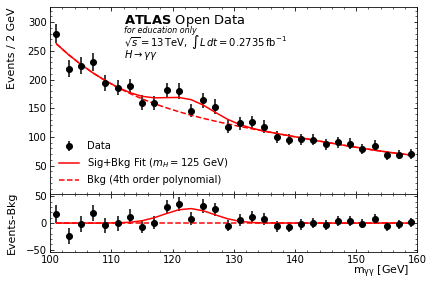

In [149]:
signal_yields,background_yields = plot_data(data)